In [19]:
# Packages
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, cohen_kappa_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
# import graphviz
# Scaling with Minmax-scaler
from sklearn.preprocessing import MinMaxScaler

# from ydata_profiling import ProfileReport

# import custom functions
from custom_functions import our_metrics

pd.set_option('display.max_rows', 150)

# # mlflow
# import mlflow
# from mlflow.models import infer_signature
# import mlflow.sklearn

# mlflow.set_tracking_uri("http://localhost:5000")
#import logging

#logging.basicConfig(level=logging.WARN)
#logger = logging.getLogger(__name__)


In [3]:
# export processed data set to csv

# export features for tree-based models
X_train_comb = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_processed.csv')
X_test_comb =pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_processed.csv')


# export target
y_train_comb = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train.csv')
y_test_comb = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test.csv')


In [4]:
gbc = GradientBoostingClassifier(n_estimators=200,subsample=1, max_leaf_nodes=31, max_features='log2', max_depth=5, loss = 'log_loss', learning_rate=0.025, random_state=42)

In [5]:
gbc.fit(X_train_comb,y_train_comb)

/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=0.025, max_depth=5,
                           max_features='log2', max_leaf_nodes=31,
                           n_estimators=200, random_state=42, subsample=1)

# Error Analysis

In [8]:
df = pd.read_csv('../data/petfinder-adoption-prediction/eda/df_eda.csv') # Import dataset without dummies.
#df = df.query('quantity == 1')

In [9]:
df_noy = df.drop("adoptionspeed",axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_noy, df["adoptionspeed"], random_state=42, stratify=df["adoptionspeed"]) # We only work with test data so the df is split again into test and train. Manually checked if the order is correct.

df_comb = X_test.reset_index()

In [12]:
df_comb["adoptionspeed"] = y_test_comb # Add the correct classes
df_comb["as_pred"] = gbc.predict(X_test_comb) # Add the predictions
df_comb["pred_correct"] = (df_comb["as_pred"] == df_comb["adoptionspeed"]).astype(int) # Check whether the correction is correct (1) or not.
df_comb["overunder_pred"] = df_comb.as_pred - df_comb.adoptionspeed # 0 is a correct prediction. Negative number is an underprediction, positive number is an overprediction.
df_comb["off"] = abs(df_comb["overunder_pred"])
df_comb["desc_bin"] = pd.qcut(df_comb["description_char"],5,labels=[0,1,2,3,4]) # Bin the description length because otherwise the prop_df would contain 1 row for every unique value in description_char

In [39]:
df_comb.age_bin.mean()

0.745850622406639

In [37]:
df_comb.groupby("off").describe().loc[:,(slice(None),['count','mean','std'])].T # have a look at the feature means for the predictions that are correct vs 1 off, 2off, 3off

off                                  0            1            2            3
index               count  1185.000000   973.000000   501.000000   233.000000
                    mean   5897.257384  5671.036999  6143.746507  5837.227468
                    std    3329.494404  3305.066042  3288.197709  3305.874078
type                count  1185.000000   973.000000   501.000000   233.000000
                    mean      0.378059     0.402878     0.417166     0.673820
                    std       0.485107     0.490729     0.493584     0.469823
gender              count  1185.000000   973.000000   501.000000   233.000000
                    mean      0.571308     0.524152     0.558882     0.570815
                    std       0.495098     0.499673     0.497017     0.496025
maturitysize        count  1185.000000   973.000000   501.000000   233.000000
                    mean      0.884388     0.899281     0.864271     0.776824
                    std       0.547693     0.519308     0.549127     0.657827
furlength           count  1185.000000   973.000000   501.000000   233.000000
                    mean      0.471730     0.476876     0.471058     0.502146
                    std       0.609125     0.600694     0.594694     0.595417
sterilized          count  1185.000000   973.000000   501.000000   233.000000
                    mean      0.763713     0.818088     0.732535     0.733906
                    std       0.424980     0.385970     0.443079     0.442866
health              count  1185.000000   973.000000   501.000000   233.000000
                    mean      0.057384     0.028777     0.037924     0.034335
                    std       0.250165     0.173307     0.201392     0.182480
color_pattern       count  1185.000000   973.000000   501.000000   233.000000
                    mean      1.072574     1.068859     1.147705     1.214592
                    std       0.892801     0.886795     0.879852     0.818089
breed_type          count  1185.000000   973.000000   501.000000   233.000000
                    mean      0.839662     0.854060     0.858283     0.772532
                    std       0.367074     0.353228     0.349108     0.420100
vaccinated_dewormed count  1185.000000   973.000000   501.000000   233.000000
                    mean      0.932489     0.965057     0.912176     1.094421
                    std       0.890357     0.863534     0.881063     0.914261
fee_bin             count  1185.000000   973.000000   501.000000   233.000000
                    mean      0.183122     0.164440     0.167665     0.197425
                    std       0.386930     0.370865     0.373942     0.398913
age_bin             count  1185.000000   973.000000   501.000000   233.000000
                    mean      0.847257     0.553957     0.756487     1.008584
                    std       0.872513     0.787255     0.802859     0.754249
photoamt_11         count  1185.000000   973.000000   501.000000   233.000000
                    mean      3.296203     3.861254     3.403194     2.738197
                    std       2.563556     2.681339     2.393556     1.672586
description_char    count  1185.000000   973.000000   501.000000   233.000000
                    mean    322.331646   331.569373   348.932136   285.175966
                    std     383.460284   338.663460   336.678742   259.853007
adoptionspeed       count  1185.000000   973.000000   501.000000   233.000000
                    mean      2.713080     2.250771     2.740519     2.107296
                    std       1.231775     0.868287     0.951070     1.450799
as_pred             count  1185.000000   973.000000   501.000000   233.000000
                    mean      2.713080     2.276465     2.608782     2.892704
                    std       1.231775     1.026717     1.237191     1.450799
pred_correct        count  1185.000000   973.000000   501.000000   233.000000
                    mean      1.000000     0.000000     0.000000     0.000000
                    st

In [ ]:
prop_df = pd.DataFrame(columns=["feature","group","n","n_prop","prop_correct","overunder"])
for cat in ['type', 'gender', 'maturitysize', 'furlength', 'sterilized',
    'health', 'quantity', 'color_pattern', 'breed_type',
    'vaccinated_dewormed', 'fee_bin', 'age_bin', 'desc_bin','photoamt_11']:
    # print(ea_data.groupby(cat)["bank_correct"].mean().reset_index())
    # print("_________")
    test_df = df_comb.groupby(cat)["pred_correct"].mean().reset_index().round(3)                                    # for each categorie level get the mean correct predictions. A value above 0.41 (baseline accuracy) shows that the categorie is predicted below avarage and vice versa.
    test_df.insert(0, "feature", test_df.columns[0])                                                                # add feature name
    test_df["n"] = df_comb.value_counts(cat,sort=False)                                                             # number of observations
    test_df["n_prop"] = round(df_comb.value_counts(cat,sort=False)/len(df_comb),3)                                  # proportion of the above
    test_df["overunder"] = df_comb.groupby(cat)["overunder_pred"].mean().reset_index().overunder_pred.round(3)      # get the mean of over and under predictions for each group. 
    test_df.columns = ["feature","group", "prop_correct","n","n_prop","overunder"]
    test_df[["feature","group","n","n_prop","prop_correct","overunder"]]
    prop_df = pd.concat([prop_df, test_df], axis=0, ignore_index=True)

prop_df.sort_values("prop_correct")
prop_df

,feature,group,n,n_prop,prop_correct,overunder
0,type,0,1686,0.583,0.437,0.062
1,type,1,1206,0.417,0.371,0.031
2,gender,0,1292,0.447,0.393,-0.049
3,gender,1,1600,0.553,0.423,0.128
4,maturitysize,0,629,0.217,0.399,-0.297
...,...,...,...,...,...,...
43,photoamt_11,7.0,85,0.029,0.294,-0.082
44,photoamt_11,8.0,46,0.016,0.326,0.261
45,photoamt_11,9.0,35,0.012,0.314,0.114
46,photoamt_11,10.0,50,0.017,0.400,0.160


# Try clustering -  Difficult to detect any pattern.

In [ ]:
df_clust = df_comb.query("pred_correct == 0").reset_index(drop=True)
df_clust = df_clust.drop(["adoptionspeed","as_pred","pred_correct","overunder_pred","desc_bin","index","quantity","photoamt"], axis = 1)


In [ ]:
df_clust.head()

,type,gender,maturitysize,furlength,sterilized,health,quantity,photoamt,color_pattern,breed_type,vaccinated_dewormed,fee_bin,age_bin,photoamt_11,description_char
0,1,0,0,0,1,0,1,2.0,2,1,0,0,0,2.0,114.0
1,0,1,1,1,1,0,1,4.0,0,1,1,0,0,4.0,209.0
2,1,0,1,0,1,0,1,6.0,2,1,1,0,0,6.0,1006.0
3,0,1,2,0,0,0,1,1.0,2,1,0,0,0,1.0,55.0
4,1,1,1,1,1,0,1,4.0,2,1,1,0,0,4.0,1629.0


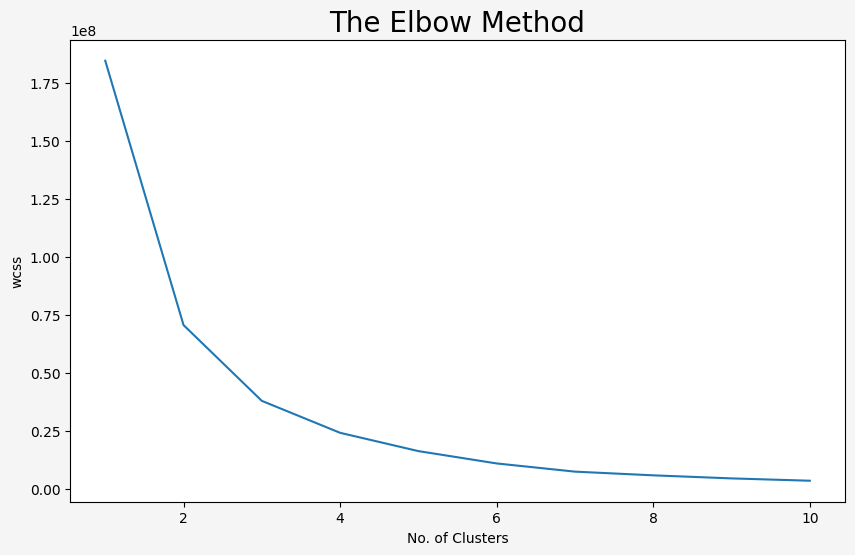

In [ ]:
# Elbow

from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(df_clust)
    wcss.append(km.inertia_)
fig=plt.figure(figsize=(10,6))  
fig.patch.set_facecolor('#f6f5f5')

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
#fig.text(0.5,0.4,"The best k-value is 5")
plt.show()

In [ ]:
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means2 = km.fit_predict(df_clust)

df_cluster2 = pd.Series(y_means2, name='Cluster')

df_clustered2 = pd.concat([df_clust, df_cluster2], axis=1)

for i in range(3):
    print(df_clustered2.query(f'Cluster == {i}').sample(4))

     type  gender  maturitysize  furlength  sterilized  health  color_pattern   
953     1       0             0          0           0       0              1  \
233     1       1             1          2           1       0              2   
43      1       1             1          0           1       0              2   
5       0       0             0          1           1       0              2   

     breed_type  vaccinated_dewormed  fee_bin  age_bin  photoamt_11   
953           1                    1        1        1          4.0  \
233           0                    0        1        0         11.0   
43            1                    0        0        0          6.0   
5             0                    0        0        2          3.0   

     description_char  Cluster  
953             890.0        0  
233            1363.0        0  
43             1013.0        0  
5               956.0        0  
      type  gender  maturitysize  furlength  sterilized  health   
1525  

In [ ]:
df_clustered2.groupby("Cluster").mean()

,type,gender,maturitysize,furlength,sterilized,health,color_pattern,breed_type,vaccinated_dewormed,fee_bin,age_bin,photoamt_11,description_char
Cluster,,,,,,,,,,,,,
0,0.500000,0.517544,0.894737,0.552632,0.701754,0.052632,1.324561,0.780702,0.649123,0.245614,0.868421,5.482456,1251.254386
1,0.421343,0.551978,0.855566,0.491260,0.812328,0.018399,1.073597,0.849126,1.024839,0.153634,0.609936,3.089236,152.489420
2,0.480237,0.521739,0.903162,0.434783,0.733202,0.057312,1.146245,0.847826,0.915020,0.187747,0.772727,4.183794,504.899209


In [ ]:
df_base = df_comb.drop(["adoptionspeed","as_pred","pred_correct","overunder_pred","desc_bin","index","quantity","photoamt"], axis = 1)
df_base.mean().T


type                     0.417012
gender                   0.553250
maturitysize             0.877248
furlength                0.475795
sterilized               0.774205
health                   0.042531
color_pattern            1.095781
breed_type               0.842324
vaccinated_dewormed      0.952974
fee_bin                  0.175311
age_bin                  0.745851
photoamt_11              3.459889
description_char       327.054288
dtype: float64

# Plotting:

In [ ]:
# set seaborn options globally
colors = ['#365b6d', '#41c1ba', '#289dd2', '#6c9286', '#f2f1ec', '#fa9939']
custom_palette = sns.set_palette(sns.color_palette(colors))
custom_params = {"axes.facecolor": "#f2f1ec", 
"figure.facecolor": "#f2f1ec",
'figure.titleweight': 'bold',
'figure.titlesize': 28,#'large',
'grid.alpha': 1.0,
'font.size': 16.0,
'font.weight': 'bold',
'axes.labelsize': 16,
'axes.labelcolor': '#365b6d',
'axes.titlepad': 10.0,
'axes.titlesize': 'large',
'xtick.labelsize': 16,
'xtick.color': '#365b6d',
'xtick.bottom': True,
'ytick.labelsize': 16,
'ytick.color': '#365b6d',
'ytick.left': True,
'text.color' : '#365b6d',
'legend.title_fontsize': 12.0,
'legend.frameon': False,
'axes.linewidth': 3,#0.8,
'axes.spines.left': True,
'axes.spines.bottom': True,
'axes.spines.right': True,
'axes.spines.top': True,
'axes.edgecolor': '#365b6d',
'axes.labelweight': 'bold',
'axes.titleweight': 'bold',
'patch.edgecolor': '#f2f1ec'
}
sns.set_theme(style="white", palette=colors, rc=custom_params)

In [ ]:
sum([0.344, 0.294, 0.326, 0.314 ]) / 4
sum([0])

0.3195

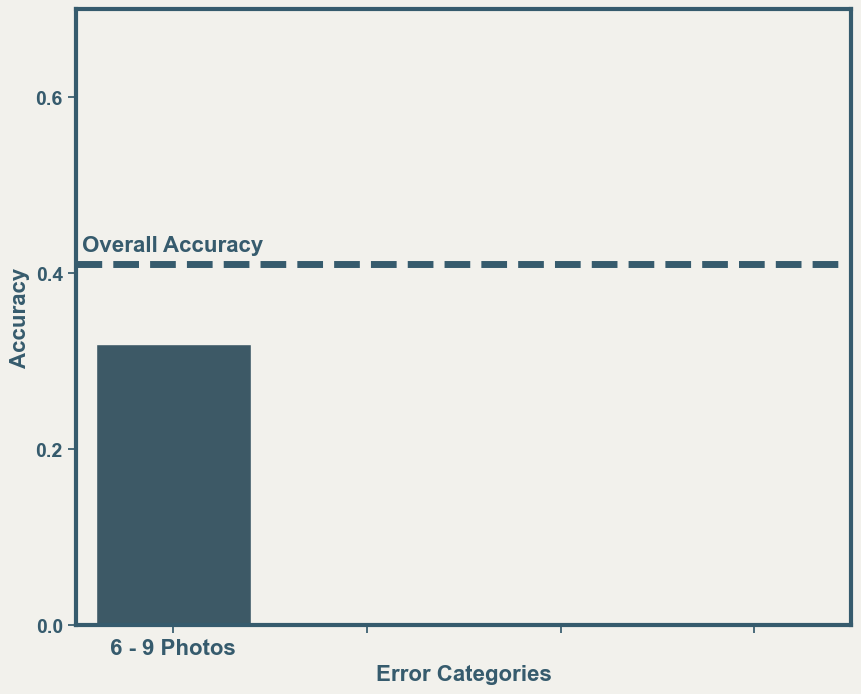

In [ ]:
# Define your data
x_values = ['6 - 9 Photos', '', ' ', "   "]
y_values = [0.32, 0, 0, 0 ]

# Create a Seaborn barplot
plt.figure(figsize=(10, 8))

# Set the y-axis limits
plt.ylim(0, 0.7)

# Create the barplot
bar_colors = ['#365b6d', '#41c1ba','#41c1ba','#41c1ba']
ax = sns.barplot(x=x_values, y=y_values,palette=bar_colors)

# Add labels and title
plt.xlabel("Error Categories")
plt.ylabel("Accuracy")

plt.yticks(color='#365b6d',fontsize=14, ticks=[0,0.2,0.4,0.6],fontweight='bold')

#plt.title("Seaborn Barplot Example")

ax.axhline(y=0.41, color='#365b6d', linestyle='--', linewidth = 5)
plt.text(0, 0.425, 'Overall Accuracy', fontsize=16, ha='center')


# Show the plot
plt.show()

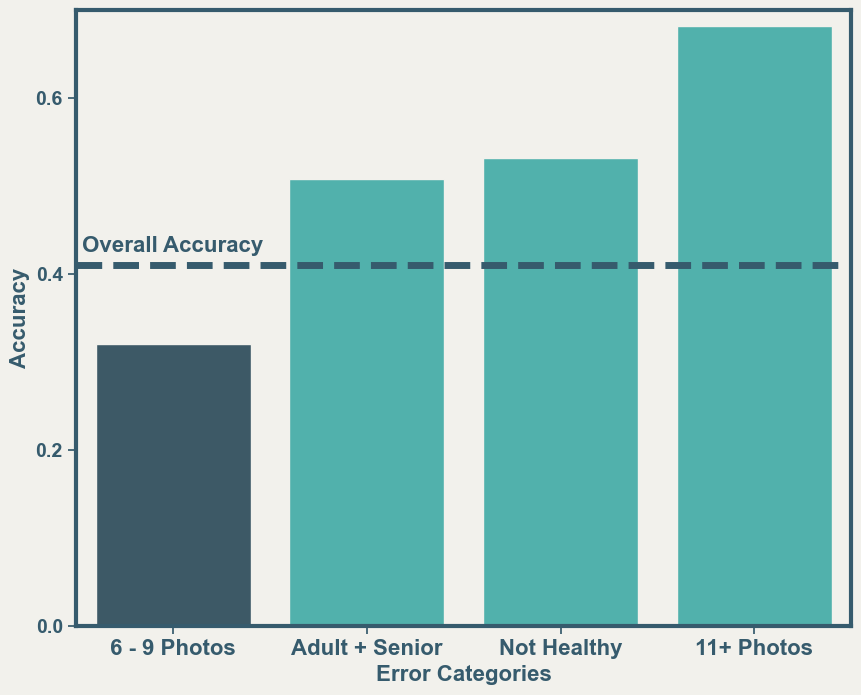

In [ ]:
# Define your data
x_values = ['6 - 9 Photos', 'Adult + Senior', 'Not Healthy', "11+ Photos"]
y_values = [0.32, 0.5075, 0.532, 0.682 ]

# Create a Seaborn barplot
plt.figure(figsize=(10, 8))

# Set the y-axis limits
plt.ylim(0, 0.7)

# Create the barplot
bar_colors = ['#365b6d', '#41c1ba','#41c1ba','#41c1ba']
ax = sns.barplot(x=x_values, y=y_values,palette=bar_colors)

# Add labels and title
plt.xlabel("Error Categories")
plt.ylabel("Accuracy")

plt.yticks(color='#365b6d',fontsize=14, ticks=[0,0.2,0.4,0.6],fontweight='bold')

#plt.title("Seaborn Barplot Example")

ax.axhline(y=0.41, color='#365b6d', linestyle='--', linewidth = 5)
plt.text(0, 0.425, 'Overall Accuracy', fontsize=16, ha='center')


# Show the plot
plt.show()

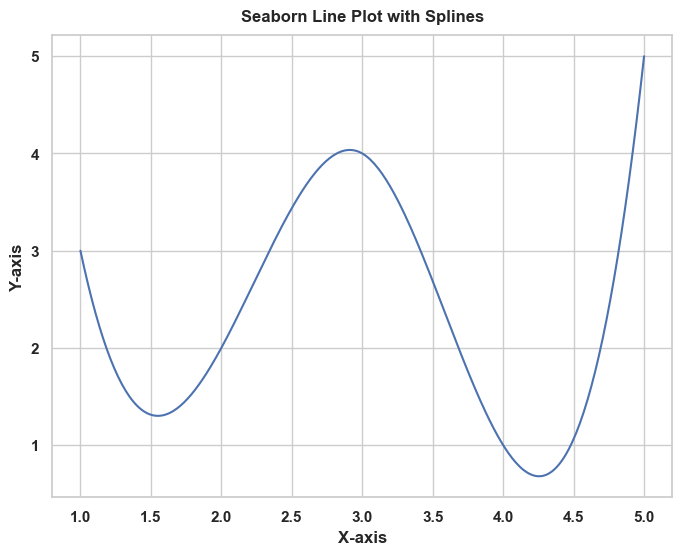

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Example data
x = [1, 2, 3, 4, 5]
y = [3, 2, 4, 1, 5]

# Create a Seaborn line plot with splines
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

x_smooth = np.linspace(min(x), max(x), 300)
spline = make_interp_spline(x, y, k=3)
y_smooth = spline(x_smooth)

sns.lineplot(x=x_smooth, y=y_smooth)

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Seaborn Line Plot with Splines")

# Show the plot
plt.show()